# Análise de Risco de Falência

## Introdução
Este notebook desenvolve um modelo de classificação utilizando redes neurais para prever o risco de falência de empresas com base em suas características financeiras. Vamos importar as principais bibliotecas:


In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Normalization
from copy import deepcopy
# Fixando a semente para numpy e tensorflow para garantir a reproducibilidade
general_random_state = 1

np.random.seed(general_random_state)
tf.random.set_seed(general_random_state)


## Carregamento de Dados
Carregamos os dados necessários para o modelo.

In [2]:
# Carrega o dataset
data_path = 'data.csv'
data = pd.read_csv(data_path)
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Análise Exploratória de Dados (EDA)
Realizando uma análise visual inicial dos dados para entender suas características. Primeiro, visualizamos todos os histogramas de todas as colunas do dataset:

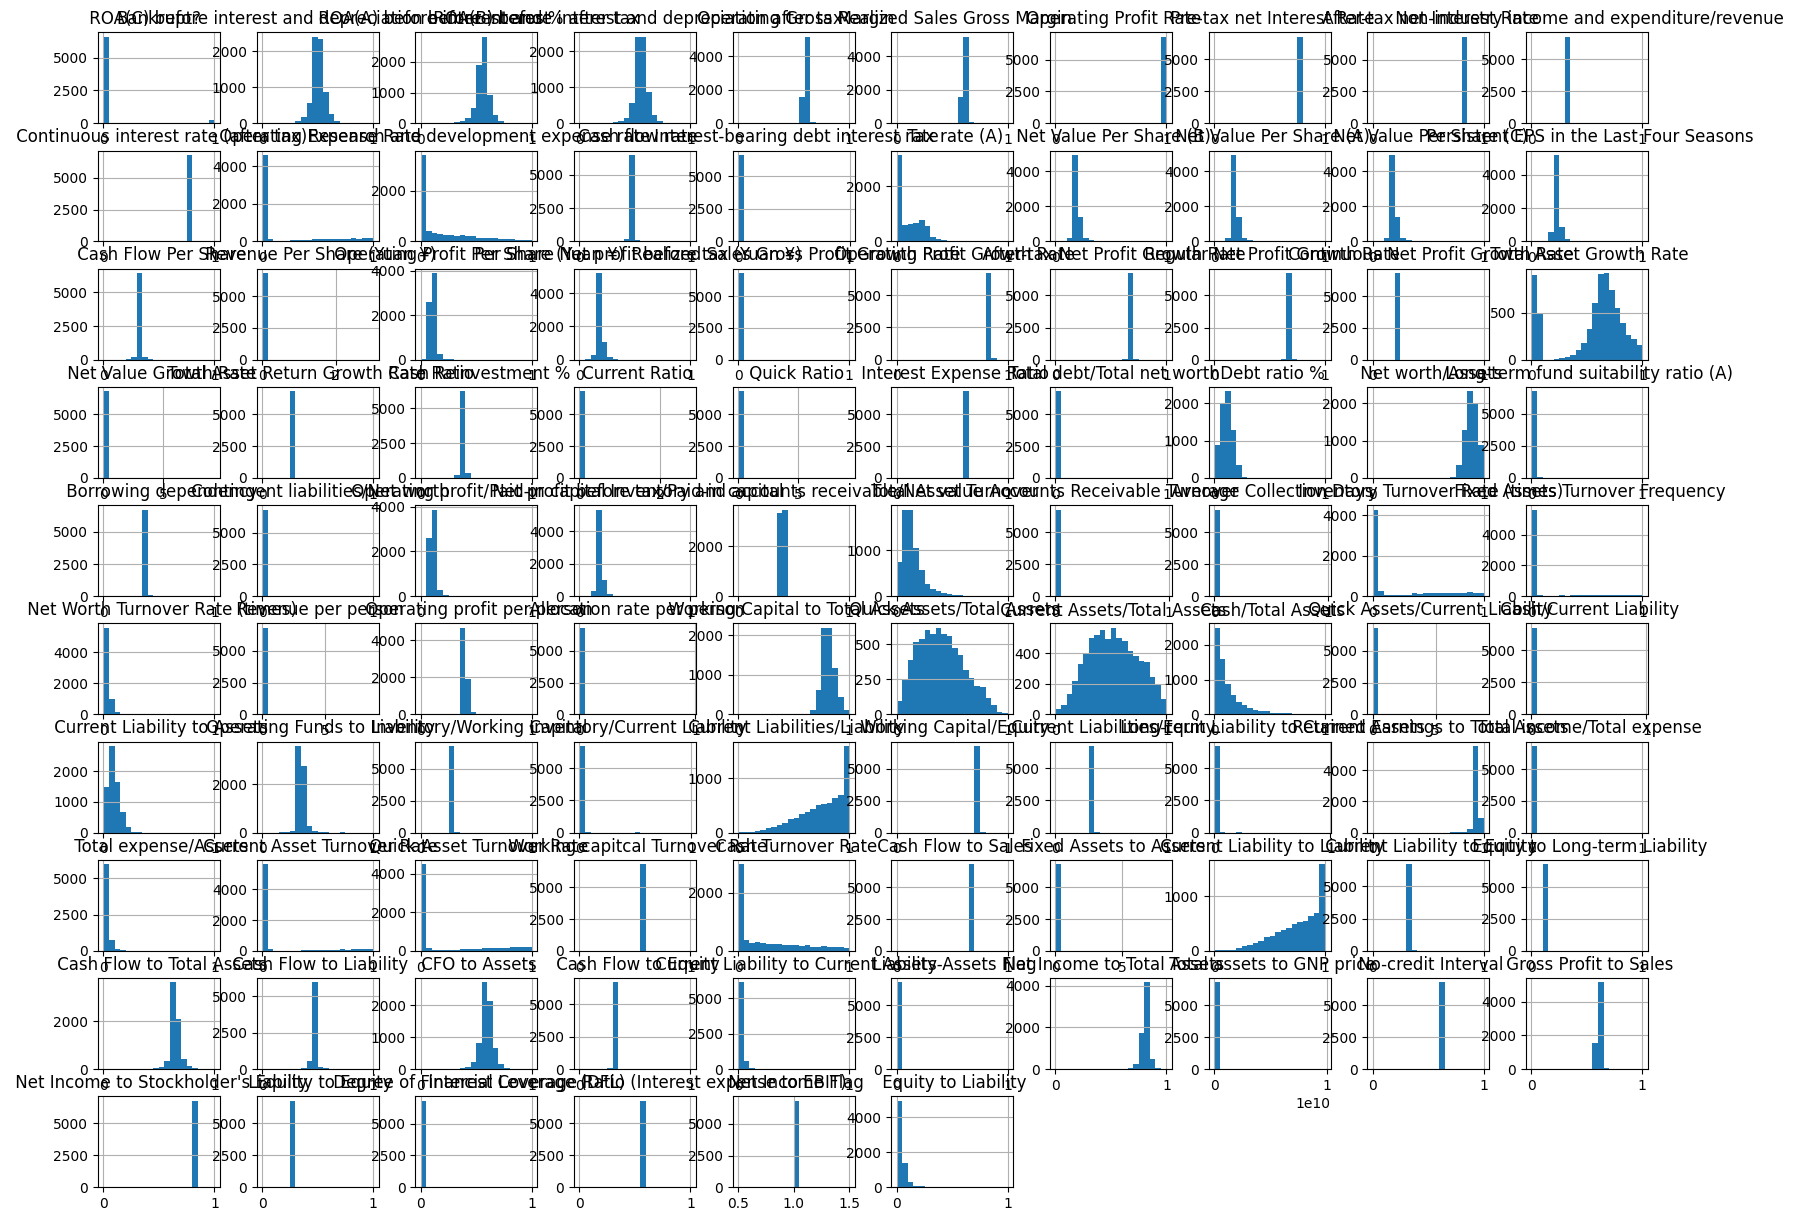

In [3]:
# Histograma de todas as características
data.hist(bins=20, figsize=(20,15))
plt.show()

Visualizando a distribuição dentro da classe alvo, onde 0 significa que a empresa não faliu, e 1 significa que a empresa faliu. Nota-se um desbalaceamento gigante dentro da classe principal, o que pode causar overfitting:


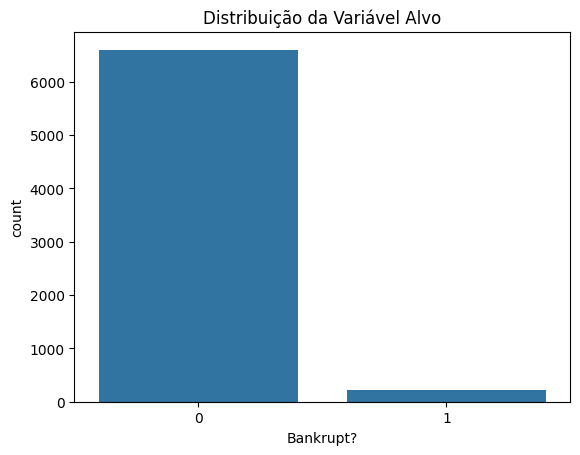

In [4]:
# Gráfico de barras para a frequência da variável alvo 'Bankrupt?'
sns.countplot(x='Bankrupt?', data=data)
plt.title('Distribuição da Variável Alvo')
plt.show()

Verificando ruídos, se há duplicatas ou valores nulos

In [5]:
for col in data.columns:
    duplicates_per_column = data.duplicated(subset=[col]).sum()
    if duplicates_per_column > 0:
        print(f"Duplicatas na coluna {col}: {duplicates_per_column}")

    nulls_per_column = data[col].isnull().sum()
    if nulls_per_column > 0:
        print(f"Valores nulos na coluna {col}: {nulls_per_column}")

Duplicatas na coluna Bankrupt?: 6817
Duplicatas na coluna  ROA(C) before interest and depreciation before interest: 3486
Duplicatas na coluna  ROA(A) before interest and % after tax: 3668
Duplicatas na coluna  ROA(B) before interest and depreciation after tax: 3659
Duplicatas na coluna  Operating Gross Margin: 3038
Duplicatas na coluna  Realized Sales Gross Margin: 3031
Duplicatas na coluna  Operating Profit Rate: 3443
Duplicatas na coluna  Pre-tax net Interest Rate: 3030
Duplicatas na coluna  After-tax net Interest Rate: 3215
Duplicatas na coluna  Non-industry income and expenditure/revenue: 4268
Duplicatas na coluna  Continuous interest rate (after tax): 3202
Duplicatas na coluna  Operating Expense Rate: 3853
Duplicatas na coluna  Research and development expense rate: 5283
Duplicatas na coluna  Cash flow rate: 1262
Duplicatas na coluna  Interest-bearing debt interest rate: 5739
Duplicatas na coluna  Tax rate (A): 4331
Duplicatas na coluna  Net Value Per Share (B): 4541
Duplicatas na

Verificando os principais quartis e tendencias do dataset

In [6]:
display(data.describe())

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


Verificando as correlações com a classe alvo do dataset

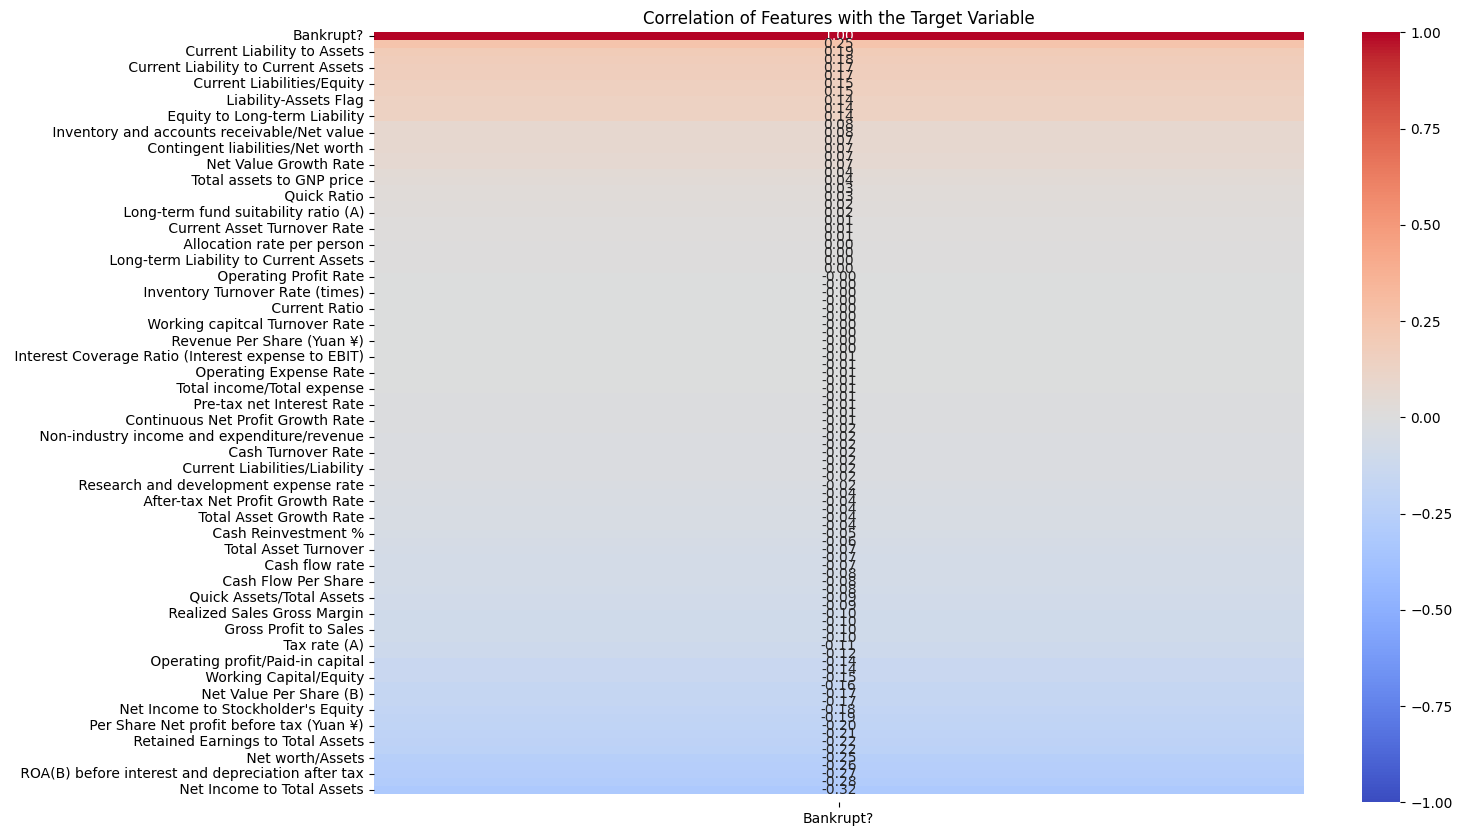

In [7]:
# Calcula as correlações
correlations = data.corr()

# Plota a correlação das características com a variável alvo 'Bankrupt?'
plt.figure(figsize=(15, 10))
sns.heatmap(correlations[['Bankrupt?']].sort_values(by='Bankrupt?', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation of Features with the Target Variable')
plt.show()

## Pré-processamento de Dados
Reduzindo o desbalanceamento da variável alvo, selecionando somente os elementos mais significativos da classe majoritária, e em seguida visualizando o novo balanceamento das classes:

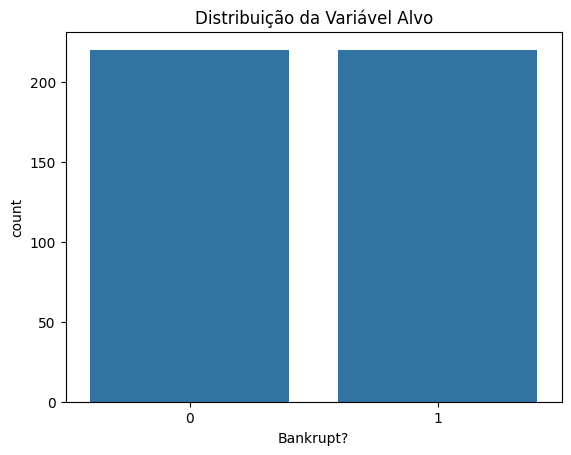

In [8]:
# Separa as classes
not_bankrupt = data[data['Bankrupt?'] == 0]

# Número de dados que queremos manter - igual ao número de falidos
n_samples = len(data[data['Bankrupt?'] == 1])

# Aplicando K-means para encontrar os centroides
kmeans = KMeans(n_clusters=n_samples, random_state=general_random_state)
kmeans.fit(not_bankrupt.drop('Bankrupt?', axis=1))  # Ignorando a coluna alvo durante o ajuste

# Identificando os índices dos pontos mais próximos dos centroides
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, not_bankrupt.drop('Bankrupt?', axis=1))

# Dados da classe minoritária
bankrupt = data[data['Bankrupt?'] == 1]

# Selecionando as amostras mais representativas
representative_samples = not_bankrupt.iloc[closest]

# Combinando as amostras representativas da classe majoritária com toda a classe minoritária
balanced_data = pd.concat([bankrupt, representative_samples])

# Embaralhando os dados para remover qualquer viés de ordenação
balanced_data = balanced_data.sample(frac=1, random_state=general_random_state).reset_index(drop=True)

# Gráfico de barras para a frequência da variável alvo 'Bankrupt?'
sns.countplot(x='Bankrupt?', data=balanced_data)
plt.title('Distribuição da Variável Alvo')
plt.show()
# balanced_data = data

Removendo as colunas de baixa variância

In [9]:
# Remove colunas de baixa variância
data_var = balanced_data.var()
low_variance_cols = data_var[data_var < 0.01].index.tolist()
data_cleaned = balanced_data.drop(columns=low_variance_cols)
data_cleaned.head()

,Bankrupt?,ROA(A) before interest and % after tax,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Revenue Per Share (Yuan ¥),Total Asset Growth Rate,Net Value Growth Rate,Quick Ratio,...,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Current Liability to Liability,Liability-Assets Flag,Total assets to GNP price
0,0,0.627780,1.127456e-04,4.600000e+09,0.000161,0.107400,0.041865,1.629142e-04,0.000754,0.014385,...,0.012094,0.489045,0.010051,2.063277e-04,1.674609e-04,2.496659e-04,0.300334,0.489045,0,0.002828
1,0,0.591092,1.200000e+09,3.570000e+08,0.000219,0.079968,0.159369,1.252054e-04,0.000483,0.005490,...,0.003680,0.996219,0.000000,7.780000e+09,6.770000e+09,4.550000e+09,0.000407,0.996219,0,0.008815
2,1,0.501145,9.180000e+09,0.000000e+00,0.000386,0.000000,0.009755,2.000000e+09,0.000245,0.001812,...,0.000000,0.854821,0.015639,6.680000e+06,7.610000e+09,4.000000e+09,0.000476,0.854821,0,0.000809
3,0,0.586241,1.792366e-04,4.180000e+09,0.000212,0.091710,0.027950,6.930000e+09,0.000464,0.006069,...,0.003031,0.494370,0.019916,8.460000e+09,7.910000e+09,1.880000e+09,0.378667,0.494370,0,0.011496
4,0,0.555877,1.977384e-04,3.940000e+09,0.000377,0.148699,0.015170,6.370000e+09,0.000471,0.002427,...,0.005015,0.750605,0.011807,1.378120e-04,8.110000e+09,1.950000e+09,0.447065,0.750605,0,0.000762


Removendo colunas que possuem alta correlação

In [10]:
correlation_matrix = data_cleaned.corr().abs()

# Selecione o triângulo superior da matriz de correlação
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Encontre as colunas com correlação maior que 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Remova as colunas
data_dropped = data_cleaned.drop(to_drop, axis=1)

Tratando outliers

In [11]:
# Identificando e tratando outliers (exemplo usando z-score ou IQR)
data_dropped = data_dropped[(np.abs(stats.zscore(data_dropped)) < 3).all(axis=1)]

Separando os dados para o modelo, considerando somente as 10 colunas com informação mutua melhor classificada


In [12]:
data_final = data_dropped
# Separa características e variável alvo
features = data_final.drop(columns='Bankrupt?')
target = data_final['Bankrupt?']

# Divide os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=general_random_state)
mi = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi, index=X_train.columns)

top_10_features = mi_series.sort_values(ascending=False).head(10)
X_train = X_train[top_10_features.index]
X_test  = X_test[top_10_features.index]

# Padroniza as características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
data_final.head()

data_final.describe()

,Bankrupt?,ROA(A) before interest and % after tax,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Revenue Per Share (Yuan ¥),Total Asset Growth Rate,Net Value Growth Rate,Quick Ratio,...,Cash/Current Liability,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Liability-Assets Flag,Total assets to GNP price
count,368.000000,368.000000,3.680000e+02,3.680000e+02,3.680000e+02,368.000000,368.000000,3.680000e+02,368.000000,368.000000,...,3.680000e+02,368.000000,368.000000,3.680000e+02,3.680000e+02,3.680000e+02,3.680000e+02,368.000000,368.0,368.000000
mean,0.491848,0.521390,2.321262e+09,1.934027e+09,2.173913e+04,0.061287,0.033917,5.048618e+09,0.000447,0.006755,...,2.577989e+07,0.007178,0.739696,7.798913e+05,1.689625e+09,2.987495e+09,2.738264e+09,0.302792,0.0,0.009196
std,0.500614,0.074343,3.403945e+09,2.545708e+09,4.170288e+05,0.100694,0.034553,2.640472e+09,0.000102,0.009424,...,2.506478e+08,0.006070,0.194689,1.496091e+07,3.261149e+09,3.613562e+09,2.729386e+09,0.212414,0.0,0.033447
min,0.000000,0.204481,1.019914e-04,0.000000e+00,0.000000e+00,0.000000,0.000197,1.000017e-04,0.000200,0.000183,...,1.008563e-04,0.000000,0.204058,0.000000e+00,1.007911e-04,0.000000e+00,1.008996e-04,0.000407,0.0,0.000193
25%,0.000000,0.489520,1.612551e-04,7.614874e-05,2.625263e-04,0.000000,0.014380,4.390000e+09,0.000398,0.002416,...,7.855242e-04,0.002872,0.599754,1.047555e-04,1.466190e-04,1.524072e-04,3.297500e+08,0.118016,0.0,0.000978
50%,0.000000,0.535543,3.464469e-04,6.025000e+08,4.090409e-04,0.000000,0.025281,5.990000e+09,0.000442,0.004429,...,2.092988e-03,0.005594,0.770362,4.644010e-03,2.218017e-04,4.342990e-04,1.890000e+09,0.273394,0.0,0.002583
75%,1.000000,0.565362,5.535000e+09,3.572500e+09,6.193119e-04,0.112613,0.042202,6.930000e+09,0.000472,0.007963,...,5.708305e-03,0.009513,0.899993,1.361742e-02,4.406052e-03,6.752500e+09,4.727500e+09,0.460030,0.0,0.006411
max,1.000000,0.809256,9.890000e+09,9.390000e+09,8.000000e+06,0.438607,0.313928,9.500000e+09,0.001015,0.095206,...,3.370000e+09,0.042583,1.000000,2.870000e+08,9.960000e+09,9.790000e+09,9.470000e+09,0.839609,0.0,0.555479


## Construção e Treinamento do Modelo KNN
Definimos e treinamos nosso modelo KNN.

In [13]:
# Treinamento KNN
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia: {accuracy:.4f}')

Acurácia: 0.7928


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


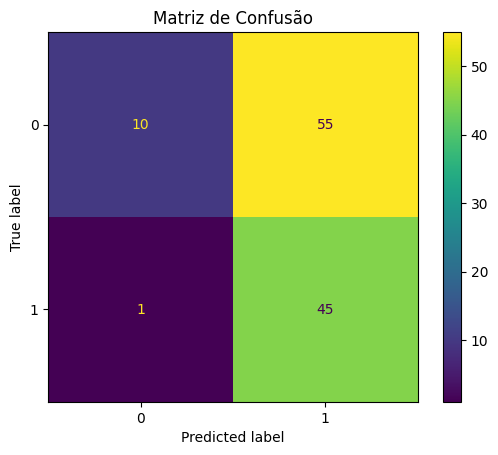

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Matriz de Confusão')
plt.show()

## Construção e Treinamento do Modelo Naive Bayes
Definimos e treinamos nosso modelo naive bayes.

In [15]:
# Treinamento Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Criação e treinamento do modelo
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Previsão
y_pred = model.predict(X_test_scaled)

# Cálculo da acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.4f}')

# Relatório de classificação
report = classification_report(y_test, y_pred)
print("Relatório de Classificação:")
print(report)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)


Acurácia: 0.5135
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.18      0.31        65
           1       0.46      0.98      0.62        46

    accuracy                           0.51       111
   macro avg       0.69      0.58      0.47       111
weighted avg       0.73      0.51      0.44       111

Matriz de Confusão:
[[12 53]
 [ 1 45]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


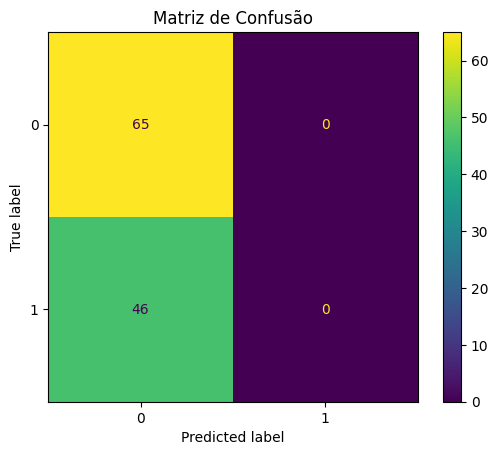

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Matriz de Confusão')
plt.show()

## Construção e Treinamento do Modelo de Rede Neural
Definimos e treinamos nosso modelo de rede neural.

In [17]:
normalizer = Normalization()
normalizer.adapt(X_train_scaled)

camadas = [
    normalizer,
    layers.Dense(8, activation='tanh'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
]

# Constrói o modelo de rede neural
model = models.Sequential(deepcopy(camadas))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treina o modelo
history = model.fit(X_train_scaled, y_train, epochs=200, validation_split=0.2)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3607 - loss: 0.7892 - val_accuracy: 0.2692 - val_loss: 0.8082
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3741 - loss: 0.7725 - val_accuracy: 0.2885 - val_loss: 0.7911
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3638 - loss: 0.7571 - val_accuracy: 0.3077 - val_loss: 0.7754
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3716 - loss: 0.7429 - val_accuracy: 0.3077 - val_loss: 0.7605
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3976 - loss: 0.7291 - val_accuracy: 0.3077 - val_loss: 0.7470
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4306 - loss: 0.7160 - val_accuracy: 0.3269 - val_loss: 0.7341
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4722 - loss: 0.7033 - val_accuracy: 0.3654 - val_loss: 0.7215
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5287 - loss: 0.6907 - val_accuracy: 0.3654 - val_loss: 0.708

## Avaliação do Modelo e Determinação da Melhor Época para Parar o Treinamento

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8398 - loss: 0.3703 
Test accuracy: 0.8468468189239502


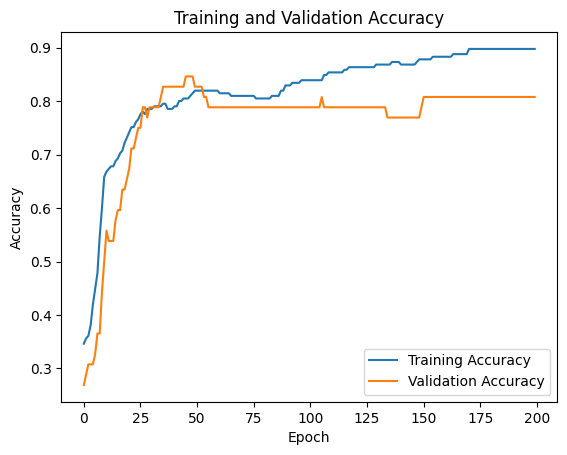

In [18]:

test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {test_acc}')

# Plot da acurácia de treinamento e validação
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Visualização de Perda durante o Treinamento
Com base no gráfico de loss e nas acurácias de treino e validação, nota-se que o ganho de acurácia e a redução do loss começa a decair a partir da 30ª epoca de treino, o que indica que esta é aproximadamente melhor época para parar de treinar e não gerar overfitting, e ainda sim obter um modelo satisfatório

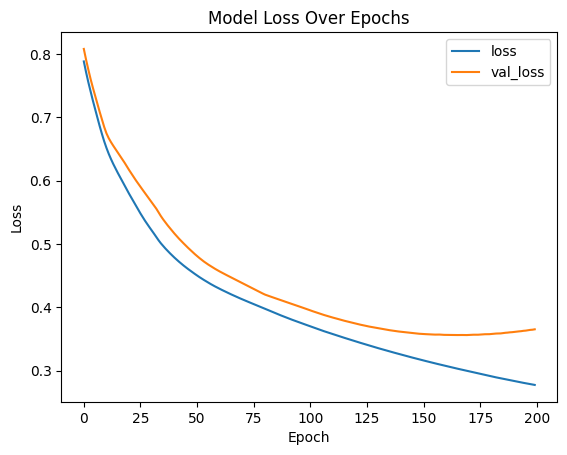

In [19]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Treinando com um número de épocas fixo
Com base no gráfico de loss e nas acurácias de treino e validação, nota-se que o ganho de acurácia e a redução do loss começa a decair significativamente a partir da 30ª epoca de treino. As melhores épocas para treinar um modelo definitivo estão entre a 30ª e a 55ª aproximadamente, provendo uma acurácia satisfatória, e sem overfitting. Vamos retreinar considerando a 40ª época:

In [20]:
# Constrói o modelo de rede neural
final_model = models.Sequential(deepcopy(camadas))

final_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Treina o modelo
history = final_model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)
test_loss, test_acc = final_model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {test_acc}')


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6551 - loss: 0.6520 - val_accuracy: 0.4808 - val_loss: 0.6688
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6750 - loss: 0.6459 - val_accuracy: 0.5192 - val_loss: 0.6632
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6787 - loss: 0.6401 - val_accuracy: 0.5192 - val_loss: 0.6576
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6758 - loss: 0.6348 - val_accuracy: 0.5192 - val_loss: 0.6522
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6837 - loss: 0.6297 - val_accuracy: 0.5192 - val_loss: 0.6470
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6647 - loss: 0.6247 - val_accuracy: 0.5385 - val_loss: 0.6421
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6647 - loss: 0.6199 - val_accuracy: 0.5962 - val_loss: 0.6371
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6666 - loss: 0.6152 - val_accuracy: 0.5962 - val_loss: 0.6322
Epoch 